# Initialization

In [1]:
import io
import json
import os

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import math

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import random

import copy

import seaborn as sns
%pylab inline

##Ignoring warnings for now
import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
%%capture
!pip install pandas matplotlib google-cloud-storage

import os
from google.colab import drive
drive.mount('/content/drive')

# Point environment variable `GOOGLE_APPLICATION_CREDENTIALS` to 
# location of service account file 'dtu-course-02456-students.json'.
#os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/content/drive/My Drive/Woodsense/Tech/Software/Deep Learning Course DTU/Students Folder/gcp-service-accounts/dtu-course-02456-students.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS']  = "/content/drive/My Drive/Colab Notebooks/02456-deep-learning-with-PyTorch/WoodSense/gcp-service-accounts/dtu-course-02456-students.json"

"""
This section connects to the drive provided by WoodSense. Click the link and authorize your google account to import it.
"""


# Defining functions for preprocessing
The following sections contains all the necessary functions for preprocessing of the data before creating and training a model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def clean_up_weather(df):
  """
  This function cleans up, interpolates and prepares the weather features of the provided. It's used in the dataloader function

  Parameters:
  df (Pandas dataframe): The chosen dataframe to be cleaned
  """
  indexes = []
  tmp_new = pd.DataFrame()
  n, i, no = 0,0,0
  for sensors in df['sensor_id'].unique():
    cur_sens = df[df['sensor_id'] == sensors]
    if pd.isnull(cur_sens['weather_humidity']).sum() > (len(cur_sens)/2):
      n += 1
      pass
    elif pd.isnull(cur_sens['weather_humidity']).sum() != 0:
      i += 1
      mask = df["sensor_id"] == sensors
      tmp_df = df[mask].set_index('timestamp').interpolate(method='time').reset_index()
      tmp_new = pd.concat([tmp_new, tmp_df])
    else:
      no += 1
      mask = df["sensor_id"] == sensors
      tmp_new = pd.concat([tmp_new,df[mask]])
  tmp_new = tmp_new.dropna()
  return tmp_new

In [5]:
def load_data(date,drop_primary_nans = True,drop_weather_nans=False):
  """
  Loads the sensor data and remove NaN values if chosen so.

  Parameters:
  date (str): date of the WoodSense data given in format YYYY-mm-dd
  drop_primary_nans (bool): Drop all rows where there is NaN in timestamp, temperature, humidity, ohms and moisture columns
  drop_temperature_nans (bool): Drop alle rows if NaN where there is weather data

  """
  df = pd.read_csv('/content/drive/My Drive/WoodSense/data/woodsense-sensor-data-' + date + '.csv')
  df.timestamp = pd.to_datetime(df.timestamp,infer_datetime_format=True,errors='coerce')
  #df = df.sort_values(by=['timestamp'])
  df = df.drop(columns=['weather_wind_min','ohms'])
  if drop_primary_nans:
    df = df.dropna(subset=['timestamp','temperature','humidity','moisture'])
  if drop_weather_nans:
    df = df.dropna(subset = ['weather_humidity','weather_pressure','weather_temp_dew','weather_temp_dry',
                        'weather_wind_dir','weather_wind_speed','weather_wind_max','weather_precip_past10min'])
  df=df[df.sensor_id!=51]
  return df

In [6]:
def feature_extract_time_(df):
  """
  Maps the hours on a day and the days of the year onto the unit circle.

  Parameters:
  df (Pandas Dataframe): The dataframe to extract time features from.
  """
  df['tod_sin'] = np.sin(df['timestamp'].dt.hour / 24 * 2 * np.pi)
  df['tod_cos'] = np.cos(df['timestamp'].dt.hour / 24 * 2 * np.pi)
  df['doy_sin'] = np.sin(df['timestamp'].dt.dayofyear / 365 * 2 * np.pi)
  df['doy_cos'] = np.cos(df['timestamp'].dt.dayofyear / 365 * 2 * np.pi)

  return df

In [7]:
def create_model_eval_set(df,test_sensors = [20,25,26,27,50],random_sensors = False):
  """
  Takes a portion of the sensors aside for a test set. By default, the sensors states by WoodSense to contain possible anomalies. Has an option to select random sensors.

  Parameters:
  df (Pandas dataframe): The dataframe with all sensors
  test_sensors (list): A list consisting of the sensors to be put aside
  random_sensors (bool): If true, puts 5 random sensors aside.
  """
  if random_sensors:
    sensors = df.sensor_id.unique()
    print(sensors)
    random.seed(42)
    test_sensors = random.choice(sensors,size=10,replace=False)
    print(test_sensors)
    
  mask = df.sensor_id.isin(test_sensors)
  df_model_eval = df[mask]

  #df_model_eval.to_csv('/content/drive/MyDrive/WoodSense/notebooks/Final models and comparison/model_eval_data.csv',sep=';',index=False)
  df = df[~mask]
  return df

In [8]:
def standardise(data,mean_and_stds=None):
  """
  Standardises each column in the data. 

  Parameters:
  data (DataFrame): Data object to standardize. Columns must not contain timestamps or strings.

  """

  if mean_and_stds is None:

    mean_and_stds = pd.DataFrame()
    measures = []
    means = []
    stds = []
    
    for col in data.columns: 
      if col not in ['timestamp','sensor_id','tod_sin','tod_cos','doy_sin','doy_cos']:
        mean = data[col].mean()
        std = data[col].std()

        measures += [col]
        means += [mean]
        stds += [std]
        data.loc[:,col] = (data[col]-mean)/std

    mean_and_stds['measure'] = measures
    mean_and_stds['mean'] = means
    mean_and_stds['std'] = stds
  
  else: 

    for m in mean_and_stds['measure'].unique():
      mean = mean_and_stds.loc[mean_and_stds['measure'] == m, 'mean'].to_numpy()
      std = mean_and_stds.loc[mean_and_stds['measure'] == m, 'std'].to_numpy()
      data.loc[:,m] = (data.loc[:,m]- mean)/std

  return data, mean_and_stds

In [9]:
def data_split(data,sensor_based = True,test_size = 0.33):
  """
  Splits the data in a train and test where split either is based on sensors or randomly chosen time-windows. 
  IMPORTANT: If split is based on sensors apply BEFORE create_inout_sequences or create_inout_sequences2.
             If split is based on random time-windows apply AFTER create_inout_sequences or create_inout_sequences2.
  
  Parameters: 
  data(DataFrame or list): Data to be split. If sensor-based split give DataFrame. If time-window based split give list. 
  sensor_based (bool): If True split is sensor based. If False split is time-window based. 
  test_size (float): The percentage of sensors or time-windows to be put aside to test set. 


  """
  import random

  if sensor_based: 
    sensors = data.sensor_id.unique().tolist()
    n_sensors = len(sensors)

    k = int(test_size*n_sensors)

    random.seed(42) #Uncomment for different splits
    test_sensors = random.sample(sensors,k)

    train = data[~data.sensor_id.isin(test_sensors)]
    test = data[data.sensor_id.isin(test_sensors)]

    train = train.sort_values(['sensor_id','timestamp'])
    test = test.sort_values(['sensor_id','timestamp'])

      

    return train, test
  else: # sensor_based = False not tested yet
    data, timestamps, data_seqs, sensors = data
    train_data, test_data, train_time, test_time, train_seqs, test_seqs, train_sensors, test_sensors = train_test_split(data, timestamps, data_seqs, sensors,test_size = test_size)
    
    return train_data, test_data, train_time, test_time, train_seqs, test_seqs, train_sensors, test_sensors


In [10]:
def drop_weather(df):
  """
  Removes weather columns
  Parameters: 
  df (DataFrame): DataFrame to remove weather columns from
  """
  if df.columns.isin([ 'weather_humidity', 'weather_pressure','weather_temp_dew', 'weather_temp_dry', 'weather_wind_dir','weather_precip_past10min', 'weather_wind_max', 'weather_wind_speed']).any():
    df = df.drop(columns=[ 'weather_humidity', 'weather_pressure','weather_temp_dew', 'weather_temp_dry', 'weather_wind_dir','weather_precip_past10min', 'weather_wind_max', 'weather_wind_speed'])
  #if df.columns.isin(['timestamp']).any():
  #  df = df.drop(columns=['timestamp'])
  return df

In [11]:
def remove_before_00(df):
  """
  Function removes all the first datarows which measurements are before 00 AM. The function is meant to work 
  in concurrence with create_inout_sequences per sensor to ensure the time-windows start from 00 AM. 

  Parameters:
  df (DataFrame): DataFrame grouped on a specific sensor

  """
  df['hour'] = df.timestamp.dt.hour
  df['day'] = df.timestamp.dt.dayofyear
  df['year'] = df.timestamp.dt.year

  min_year = df.year.min()
  min_day_in_min_year = df[df.year == min_year].day.min()

  df = df.sort_values(['timestamp'])

  if (df.head(1)['hour'].values == 0):
    return df.drop(columns=['hour','day','year'])
  else:
    df = df[(df.year >= min_year) & (df.day >= min_day_in_min_year+1)]
    return df.drop(columns=['hour','day','year'])


In [12]:
def create_inout_sequences2(input_data, tw, target_size = 1, 
                            step_size = 1,moisture=True,
                            start_from_midnight=True,std_on_sensor=False,
                            mean_and_std = None):
    '''
    Function that generates sequences based on the current time steps
    input_data = The unsctructured data from Woodsense
    tw = timewindow/timestemp we want to look back on
    target_size = how many hours we want to predict // For anomaly detection this would most likely be 1
    step_size = How many steps the window takes over the time series
    moisture = Choose moisture or ohms. If moisture = True then ohms is removed and vice versa. 

    ! Note: 
    mean_and_std is only applicable if data is standardised with global mean and standard deviation. 
    '''
    inout_seq = []
    label = []
    timestamps = []
    train = []
    sensor_list = []
    print('Number of sensors: ',len(input_data['sensor_id'].unique()))

    #if moisture:
    #  input_data = input_data.drop(columns=['ohms'])
    #else:
    #  input_data = input_data.drop(columns=['moisture'])

    if std_on_sensor is False:
      data, mean_and_std = standardise(input_data,mean_and_std)

    for sensors in input_data['sensor_id'].unique():
      data = input_data.loc[input_data['sensor_id'] == sensors]

      if start_from_midnight:
        data = remove_before_00(data)

      timestamp = data.timestamp.astype(int).to_numpy()#.tolist()
      

      data = data.drop(columns=['timestamp'])

      first = data.iloc[0]
      last = data.iloc[-1]
      L = len(data)
      if std_on_sensor:
          data, mean_and_std = standardise(data,mean_and_std)

      data = data.drop(columns=[ 'sensor_id'])
      features = data.columns.tolist()
      data = data.astype(np.float32).to_numpy().tolist()
      data = torch.FloatTensor(data)
      for i in range(0,L-tw-target_size, step_size):
        train_seq = data[i:i+tw]
        label_seq = data[i+tw:i+tw+target_size]
        timestamp_seq = timestamp[i:i+tw]
        #print(len(timestamp_seq))
        train.append(train_seq)
        label.append(label_seq)
        timestamps.append(timestamp_seq)
        inout_seq.append((train_seq ,timestamps))
        sensor_list += [sensors]
    return train, timestamps, inout_seq, sensor_list, mean_and_std, features

In [13]:
class DatasetPrediction(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, data, labels):
        'Initialization'
        self.labels = torch.tensor(labels)
        self.data = torch.tensor(data)

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

  def __getitem__(self, idx):
        'Generates one sample of data'
        # Load data and get label
        X = self.data[index]
        y = self.labels[index]

        return X, y

In [14]:
class DatasetAE(torch.utils.data.Dataset):
  """
  DataLoader is meant for AutoEncoders
  """

  def __init__(self,data,timestamps,sensors):
    super(DatasetAE, self).__init__()

    self.data = data
    self.timestamps = timestamps
    #print(len(timestamps[0]))
    self.sensors = sensors

  def __len__(self):
    return len(self.data)
 
  def __getitem__(self,idx):
    d = self.data[idx]
    t = self.timestamps[idx]
    s = self.sensors[idx]

    return d, t, np.array([s])

In [15]:
def Dataloader_Creator(date, drop_primary_nans = True, 
                       drop_weather_nans = False, 
                       drop_weather_data = True,
                       feature_extract_time = True,
                       sensor_based_split = True,
                       tw = 24, step_size = 24,
                       start_from_midnight=True,
                       batch_size=32, test_size = 0.33,
                       std_on_sensor=False
                       ):
  

  """
  Creates torch train and test dataloader classes creating batches with time-windows for each sensor. 

  Parameters: 
  date (str): Date of dataset. 
  drop_primary_nans (bool): If True all Woodsense sensor data rows with NaN values will be removed. 
  drop_temperature_nans (bool): If True all weather data rows with NaN values will be removed. 
  drop_weather_data (bool): If True all weather columns are dropped. 
  sensor_based_split (bool): If True the train and test set will be split according to sensors and if False according to time-windows. 
  If False they will be split according to made time-windows. 
  tw (int): Length of time window. 
  target_size (int): Size of target value to predict. If to work create_inout_sequences2 must be changed to create_inout_sequences
  step_size (int): Distance from the start of each time-window. 
  moisture (bool): If True ohms will be removed and vice versa. 
  start_from_midnight (bool): If True, the first time-window will start from 00:00
  batch_size (int): Batch size
  test_size (int): Ratio size of either number of time-windows or number of sensors affecting the size of the test set. 

  """
  
  df = load_data(date = date,
                 drop_primary_nans = drop_primary_nans,
                 drop_weather_nans = drop_weather_nans)
  
  print('Sensors before cleaning: ',len(df.sensor_id.unique()))
  
  if drop_weather_data:
    df = drop_weather(df)
  else:
    df = clean_up_weather(df)
    print('Sensors after cleaning: ',len(df.sensor_id.unique()))

  if feature_extract_time:
    df = feature_extract_time_(df)

  df = create_model_eval_set(df,random_sensors=False)

  if sensor_based_split:
    train, test = data_split(df,sensor_based=sensor_based_split,test_size=test_size)

    train_data, train_time, train_seqs, train_sensors, mean_and_std, features  = create_inout_sequences2(train,tw=tw,
                                                                                           step_size=step_size,
                                                                                            start_from_midnight=start_from_midnight,
                                                                                            mean_and_std=None)
    test_data, test_time, test_seqs, test_sensors, mean_and_std, features = create_inout_sequences2(test,tw=tw,
                                                                                      step_size=step_size,
                                                                                      start_from_midnight=start_from_midnight,
                                                                                      mean_and_std = mean_and_std)

  else:
    data, timestamps, seqs, sensor_list, mean_and_std, features = create_inout_sequences2(df,tw=tw,
                                                                  step_size=step_size,
                                                                  start_from_midnight=start_from_midnight)
    
    splits = data_split((data,timestamps,seqs,sensor_list),sensor_based=sensor_based_split,test_size=test_size)

    train_data, test_data, train_time, test_time, train_seqs, test_seqs, train_sensors, test_sensors = splits
  
  train_data = DatasetAE(train_data,train_time,train_sensors)
  test_data = DatasetAE(test_data,test_time,test_sensors)

  train_loader = DataLoader(train_data,batch_size=batch_size, shuffle=True, num_workers=8)
  test_loader = DataLoader(test_data,batch_size=batch_size, shuffle=False, num_workers=8)


  return (train_loader,test_loader), (train_time,test_time), (train_seqs,test_seqs), (train_sensors,test_sensors), mean_and_std, features

# Data preprocessing 
Executing the functions made

In [16]:
 sensor_based_split = True
 
 loaders, timestamps, seqs, sensor_list, mean_and_std, features = Dataloader_Creator(date='2020-11-30-cleaned', drop_primary_nans = False, 
                                                                                    drop_weather_nans = False, 
                                                                                    drop_weather_data = False,
                                                                                    feature_extract_time = True,
                                                                                    sensor_based_split = sensor_based_split,
                                                                                    tw = 24, step_size = 24, 
                                                                                    batch_size=64, test_size = 0.2)

Sensors before cleaning:  65
Sensors after cleaning:  65
Number of sensors:  48
Number of sensors:  12


In [17]:
"""
Save mean and std. dev. for training set to be used to standardise test set 
#when comparing models
"""
#mean_and_std.to_csv('/content/drive/MyDrive/WoodSense/notebooks/Final models and comparison/mean_and_std_train.csv',sep=';',index=False)
#print(mean_and_std)

'\nSave mean and std. dev. for training set to be used to standardise test set \n#when comparing models\n'

## Test if dataloader works correctly

In [18]:
train_loader, test_loader = loaders
batch = next(iter(train_loader))
train_batch, time_batch, sensor_batch = batch
train_batch.shape, time_batch.shape, sensor_batch.shape

(torch.Size([64, 24, 14]), torch.Size([64, 24]), torch.Size([64, 1]))

In [19]:
train_sensor_list, test_sensor_list = sensor_list

# Testing if the unique number of sensors in train and test sums up to 60
# Relevant test if sensor_based_split = True
if sensor_based_split:
  assert len(set(train_sensor_list)) +  len(set(test_sensor_list)) == 60

# Create GRU Auto-Encoder
In this section, the autoencoder is created 

## Functions for GRU Auto-Encoder

In [20]:
class Encoder(nn.Module):
  """
  Definition of the encoder consisting of two GRUs
  """
  def __init__(self, seq_len, n_features_in, embedding_dim=64,dropout=0,num_layers=1,bidirectional=True):
    super(Encoder, self).__init__()
    if bidirectional:
      self.num_directions = 2
    else:
      self.num_directions = 1

    self.seq_len =  seq_len
    self.n_features = n_features_in
    self.embedding_dim = embedding_dim
    self.hidden_dim1 = 2 * embedding_dim 
    self.hidden_dim2 = int((2 * embedding_dim)*self.num_directions)

    self.rnn1 = nn.GRU(
      input_size=self.n_features,
      hidden_size= self.hidden_dim1,
      num_layers=num_layers,
      batch_first=True,
      dropout = 0,
      bidirectional = bidirectional
    )

    self.rnn2 = nn.GRU(
      input_size=self.hidden_dim2,
      #hidden_size= int(embedding_dim/self.num_directions),
      hidden_size = embedding_dim,
      num_layers=num_layers,
      batch_first=True,
      dropout = 0,
      bidirectional = bidirectional
    )
  

  def forward(self, x):
    x, _ = self.rnn1(x)
    x,hidden_n = self.rnn2(x)
    hidden_n = hidden_n.permute(1,0,2)

    return hidden_n

In [21]:
class Decoder(nn.Module):
  """
  Definition of the decoder consisting of the repetition layer, two GRUs and the fully connected layer to the output
  """
  def __init__(self, seq_len, input_dim=64, n_features_out=3,dropout=0,num_layers=1,bidirectional=False):
    super(Decoder, self).__init__()
    if bidirectional:
      self.num_directions = 2
    else:
      self.num_directions = 1

    self.seq_len = seq_len
    self.input_dim1 = input_dim
    self.hidden_size1 = input_dim

    self.input_dim2 = self.hidden_size1 * self.num_directions
    self.hidden_size2 = int(2*self.input_dim2/self.num_directions)

    self.n_features = n_features_out
    self.num_layers = num_layers

    self.rnn1 = nn.GRU(
      input_size=input_dim,
      hidden_size= self.hidden_size1,
      num_layers=num_layers,
      batch_first=True,
      dropout = 0,
      bidirectional = bidirectional
    )

    self.rnn2 = nn.GRU(
      input_size= self.input_dim2,
      hidden_size= self.hidden_size2,
      num_layers=num_layers,
      batch_first=True,
      dropout = 0,
      bidirectional = bidirectional
    )

    
    self.output_layer = nn.Linear(self.hidden_size2*self.num_directions, n_features_out)

    self.repetitions = int(self.seq_len/(self.num_layers*self.num_directions))

  def forward(self, x):
    x = x.repeat(1,self.repetitions, 1)
    x, hidden_n = self.rnn1(x)
    x, hidden_n = self.rnn2(x)

    return self.output_layer(x)

In [22]:
class RecurrentAutoencoder(nn.Module):
  """
  Implementing the Autoencoder
  """
  def __init__(self, seq_len,n_features_in, n_features_out, embedding_dim=64,dropout=0,num_layers=1,bidirectional=False):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len=seq_len, n_features_in=n_features_in, embedding_dim = embedding_dim,
                           dropout=dropout,num_layers=num_layers,bidirectional=bidirectional).to(device)
    self.decoder = Decoder(seq_len=seq_len, input_dim = embedding_dim, n_features_out = n_features_out,
                           dropout=dropout,num_layers=num_layers,bidirectional=bidirectional).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

## Hyper-parameters for model

In [23]:
seq_len = 24 # hours in the day
embedding_dim = 32 

n_features_in = len(features)
n_features_out = 3

model = RecurrentAutoencoder(seq_len, n_features_in=n_features_in, n_features_out = n_features_out,
                             embedding_dim=embedding_dim, dropout=0.99, num_layers=1, bidirectional=True)
model = model.to(device)

In [24]:
output_test = model(train_batch.to(device))
output_test.shape

torch.Size([64, 24, 3])

# Training
After the model has been defined, it can now be trained

## Defining train function

In [25]:
def train_model(model, train_dataset, val_dataset, n_epochs,only_sensor_labels=True):
  """
  Function for training the model.

  Parameters:
  model: The autoencoder model
  train_dataset: The dataloader for the training dataset
  val_dataset: The dataloader for the validation dataset
  n_epochs: The amount of epochs to train
  only_sensor_labels: if True, only reconstructs moisture, temperature and humidity

  Returns:
  Model.eval
  History of training and validation losses
  """
  import copy
  from IPython.display import clear_output
  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
  criterion = nn.L1Loss(reduction='mean').to(device)
  history = dict(train=[], test=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for batch in train_loader:
      seq_true, _ , _ = batch
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      if only_sensor_labels:
        seq_true = seq_true[:,:,0:3]

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())
      
    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for batch in test_loader:
        seq_true, _, _ = batch

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)
        
        if only_sensor_labels:
          seq_true = seq_true[:,:,0:3]

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['test'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    #if epoch % 10 == 0:
    if epoch > 15:
      clear_output(wait=True)
      print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
      print(f'Current best test loss {best_loss}')
      train = history['train'][10:]
      test = history['test'][10:]
      n_range = list(range(10,len(train)+10))
      plt.plot(n_range,train,label='train')
      plt.plot(n_range,test,label='test')
      plt.legend()
      plt.show()


  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [26]:
def test_loss_calculator(model,loader,Loss_type = 'L2',only_sensor_labels=True):
  """
  Function for calculating the loss of all datapoints

  Parameters:
  model: The trained model
  Loss_type: L1 or L2 loss
  only_sensor_labels: If True: only calculates loss for moisture, temperature and humidity.

  returns:
  The mean of the losses
  The true sequences
  The predicted (reconstructed) sequences
  """
  if Loss_type == 'L2':
    criterion = nn.MSELoss(reduction='mean').to(device)
  elif Loss_type == 'L1':
    criterion = nn.L1Loss(reduction='mean').to(device)
  else:
    print('Choose either L1 or L2 in Loss_type')
    return

  val_losses = []

  true_seqs = []
  pred_seqs = []

  model = model.eval()
  with torch.no_grad():
    for batch in loader:
      seq_true, _, _ = batch

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      if only_sensor_labels:
        seq_true = seq_true[:,:,0:3]

      loss = criterion(seq_pred, seq_true)

      val_losses.append(loss.item())

      seq_true = seq_true.cpu().numpy()
      seq_pred = seq_pred.cpu().numpy()

      true_seqs += [seq_true]
      pred_seqs += [seq_pred]

    return np.mean(val_losses), true_seqs, pred_seqs


In [27]:
def save_model_all(model, save_dir, model_name, epoch):
    """
    Saves the trained model

    Parameters
    model: The model to be saved
    save_dir: Directory to save the model in
    model_name: Name of the model, used for creating the filename
    epoch: Number of epochs trained, used for creating the filename

    returns: None
    """
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    save_prefix = os.path.join(save_dir, model_name)
    save_path = '{}_epoch_{}.pt'.format(save_prefix, epoch)
    print("save all model to {}".format(save_path))
    output = open(save_path, mode="wb")
    torch.save(model, output)
    # torch.save(model.state_dict(), save_path)
    output.close()

## Train model

Epoch 200: train loss 0.037816930072087994 val loss 0.045940304707203596
Current best test loss 0.04384994347180639


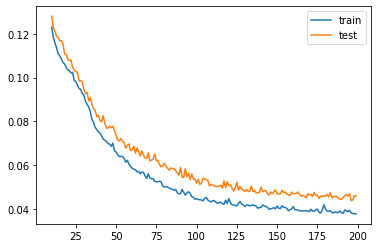

In [28]:
model, history = train_model(
  model, 
  train_loader, 
  test_loader, 
  n_epochs=200
)

In [29]:
loss, true_seqs, pred_seqs = test_loss_calculator(model,test_loader,Loss_type='L2')

Saving the trained model

In [30]:
#save_model_all(model, '/content/drive/My Drive/WoodSense/notebooks/Final models and comparison', 'GRU_AE', 1000)

# Reconstruction Error plots
Time to evaluate the model after training. This section contains a lot of plots: Highest and lowest losses of all 3 considered parameters, boxplots of losses per hour and overall and histograms of point- and 24h mean losses.

## Functions for plotting

In [31]:
def create_dataframe(true_seqs,pred_seqs,time_step = 4,m_type = 'moisture'):
  cols = [str(i) + ' - ' + str(i+time_step) for i in range(0,24,time_step)]
  """
  Creates a dataframe of sorted timeperiods, true and predicted (reconstructed) values and the euclidean distance between the prediction and the truth.

  Parameters:
  true seqs: The true values
  pred_seqs: the predicted values
  time_step: the amount of hours to step
  m_type: For choosing between 'moisture', 'temperature' and 'humidity' or -1 for euclidean distance.
  """
  measure_dict = {'temperature':0,'humidity':1,'moisture':2,'euclidian_all':-1}
  m_idx = measure_dict[m_type]
  if m_idx == -1:
    df = pd.DataFrame({'time-period':[],
                        'true_temperature':[],
                        'pred_temperature':[],
                        'true_humidity':[],
                        'pred_humidity':[],
                        'true_moisture':[],
                        'pred_moisture':[],
                        'Euclidian_distance':[]})    
  else:
    df = pd.DataFrame({'time-period':[],
                      'true':[],
                      'pred':[],
                      'L1Loss':[],
                      'L2Loss':[]})

  for true_batch, pred_batch in zip(true_seqs,pred_seqs):
    for i,t in enumerate(range(0,24,time_step)):
        if m_idx == -1:
          true_timestep = true_batch[:,t:t+time_step]
          pred_timestep = pred_batch[:,t:t+time_step]
          col_timestep = [cols[i]] * len(true_timestep)

          euclidian_distance = np.linalg.norm(true_timestep - pred_timestep,ord=2,axis=2).squeeze()

          df_tmp = pd.DataFrame({'time-period':col_timestep,
                        'true_temperature':true_timestep[:,0,0],
                        'pred_temperature':pred_timestep[:,0,0],
                        'true_humidity':true_timestep[:,0,1],
                        'pred_humidity':pred_timestep[:,0,1],
                        'true_moisture':true_timestep[:,0,2],
                        'pred_moisture':pred_timestep[:,0,2],
                        'Euclidian_distance':euclidian_distance})
          
          df = df.append(df_tmp)
        else:
          true_timestep = true_batch[:,t:t+time_step,m_idx].reshape(-1)
          pred_timestep = pred_batch[:,t:t+time_step,m_idx].reshape(-1)

          col_timestep = [cols[i]] * len(true_timestep)

          L2_loss = (true_timestep - pred_timestep)**2
          L1_loss = np.absolute(true_timestep - pred_timestep)

          df_tmp = pd.DataFrame({'time-period':col_timestep,
                        'true':true_timestep,
                        'pred':pred_timestep,
                        'L1Loss':L1_loss,
                        'L2Loss':L2_loss})
          
          df = df.append(df_tmp)

  return df

In [32]:
#create_dataframe(true_seqs,pred_seqs,time_step=1,m_type='euclidian_all')

In [33]:
def plot_scatter(true_seqs,pred_seqs,time_step=4,m_type='moisture',figsize=(20,10),alpha=0.8):
  """
  Makes a scatterplot of the true values vs. the predicted values

  Parameters:
  true_seqs: The true sequences
  pred_seqs: The predicted (reconstructed) sequences
  time_step: The amount of hours
  m_type: For choosing between 'moisture', 'temperature' and 'humidity' 
  """
  df = create_dataframe(true_seqs,pred_seqs,time_step,m_type)
  plt.figure(figsize=figsize)
  sns.scatterplot(data=df, x="true", y="pred", hue="time-period",alpha=alpha)
  plt.show()

In [34]:
def calc_global_losses(model, loader):
  """
  Calculates the global losses used in plotting

  Parameters:
  model: The trained model
  loader: The test_loader
  """
  temp_pred_out, humidity_pred_out, moisture_pred_out = [],[],[]
  temp_true_out, humidity_true_out, moisture_true_out = [],[],[]
  sensors_out, timestamps_out = [], []
  temp_losses, humidity_losses, moisture_losses = [],[],[]
  criterion = nn.L1Loss(reduction='mean').to(device)
  with torch.no_grad():
    for batch in loader:
      test_batch, timestamps, sensor = batch
      test_batch = test_batch.to(device)
      batch_temp_losses, batch_humidity_losses, batch_moisture_losses = [],[],[]
      for sample_num in range(test_batch.shape[0]):
        temp_true = test_batch[sample_num,:,0]
        humidity_true = test_batch[sample_num,:,1]
        moisture_true = test_batch[sample_num,:,2]
        
        temp_true_out.append(temp_true.cpu().numpy())
        humidity_true_out.append(humidity_true.cpu().numpy())
        moisture_true_out.append(moisture_true.cpu().numpy())

        seq_true = test_batch[sample_num].unsqueeze(0)
        seq_pred = model(seq_true)

        temp_pred = seq_pred[0,:,0]
        humidity_pred = seq_pred[0,:,1]
        moisture_pred = seq_pred[0,:,2]

        temp_pred_out.append(temp_pred.cpu().numpy())
        humidity_pred_out.append(humidity_pred.cpu().numpy())
        moisture_pred_out.append(moisture_pred.cpu().numpy())

        temp_loss = criterion(temp_pred, temp_true)
        humidity_loss = criterion(humidity_pred, humidity_true)
        moisture_loss = criterion(moisture_pred, moisture_true)

        temp_losses.append(temp_loss.item())
        humidity_losses.append(humidity_loss.item())
        moisture_losses.append(moisture_loss.item())

        timestamp = timestamps[sample_num,:]
        timestamps_out.append(pd.to_datetime(timestamp.numpy()).to_numpy())
        sensors_out.append(sample_num)

  temp_losses = np.array(temp_losses)
  humidity_losses = np.array(humidity_losses)
  mosture_losses = np.array(moisture_losses)

  return temp_losses, humidity_losses, moisture_losses, sensors_out, timestamps_out, temp_pred_out, humidity_pred_out, moisture_pred_out, temp_true_out, humidity_true_out, moisture_true_out

def calc_highest_losses(losses,n):
  """
  Calculates the n highest losses of all the losses

  Parameters:
  losses: a list of losses
  n: the n number of highest losses
  """
  losses_copy = np.copy(losses)
  max_losses_idx = np.argsort(losses_copy)
  sorted_losses = losses_copy[max_losses_idx]
  max_losses_idx = np.flip(max_losses_idx[-n:])
  max_losses = losses_copy[max_losses_idx]
  return max_losses, max_losses_idx

def calc_lowest_losses(losses,n):
  """
  Calculates the n lowest losses of all the losses

  Parameters:
  losses: a list of losses
  n: the n number of lowest losses
  """
  losses_copy = np.copy(losses)
  min_losses_idx = np.argsort(losses_copy)
  sorted_losses = losses_copy[min_losses_idx]
  min_losses_idx = min_losses_idx[:n]
  min_losses = losses_copy[min_losses_idx]
  return min_losses, min_losses_idx

def plotGlobalLosses(true_seq,pred_seq,time,max_losses_idx,min_losses_idx,sensor,temp_losses,humid_losses,moist_losses,param):
  """
  Makes plots of the n highest and lowest losses

  Parameters:
  true_seq: The values of the true losses
  pred_seq: The values of the predicted (reconstructed) losses
  time: The time of the corresponding losses
  max_losses_idx the index of the highest losses to plot for the parameter 'param'
  min_losses_idx the index of the lowest losses to plot for the parameter 'param'
  sensor: The corresponding sensor where the loss has been calculated
  temp_losses: The temperature losses
  humid_losses: The humidity losses
  moist_losses: The moisture losses
  param: can be 'moisture', 'temperature' or 'humidity'
  """
  n_subplots = len(max_losses_idx)
  fig, ax=plt.subplots(1,n_subplots,figsize=(20, 4),sharey=False)
  for count, idx in enumerate(max_losses_idx):
    if param == 'temperature':
      ax[count].plot(time[idx],pred_seq[idx],'b-',label='prediction')
      ax[count].plot(time[idx],true_seq[idx],'g-',label='truth')
      ax[count].set_title('Sensor %i - Loss %f' %(sensor[idx],moist_losses[idx]))
      fig.suptitle('5 worst temperature losses', fontsize=16)
    elif param == 'humidity':
      ax[count].plot(time[idx],pred_seq[idx],'b-',label='prediction')
      ax[count].plot(time[idx],true_seq[idx],'g-',label='truth')
      ax[count].set_title('Sensor %i - Loss %f' %(sensor[idx],moist_losses[idx]))
      fig.suptitle('5 worst humidity losses', fontsize=16)
    elif param == 'moisture':
      ax[count].plot(time[idx],pred_seq[idx],'b-',label='prediction')
      ax[count].plot(time[idx],true_seq[idx],'g-',label='truth')
      ax[count].set_title('Sensor %i - Loss %f' %(sensor[idx],moist_losses[idx])) 
      fig.suptitle('5 worst moisture losses', fontsize=16)

  for ax in fig.axes:
    ax.tick_params(labelrotation=45)
    ax.grid()
    ax.legend()
  plt.show()

  fig, ax=plt.subplots(1,n_subplots,figsize=(20, 4),sharey=False)
  for count, idx in enumerate(min_losses_idx):
    if param == 'temperature':
      ax[count].plot(time[idx],pred_seq[idx],'b-',label='prediction')
      ax[count].plot(time[idx],true_seq[idx],'g-',label='truth')
      ax[count].set_title('Sensor %i - Loss %f' %(sensor[idx],moist_losses[idx]))
      fig.suptitle('5 best temperature losses', fontsize=16)
    elif param == 'humidity':
      ax[count].plot(time[idx],pred_seq[idx],'b-',label='prediction')
      ax[count].plot(time[idx],true_seq[idx],'g-',label='truth')
      ax[count].set_title('Sensor %i - Loss %f' %(sensor[idx],moist_losses[idx]))
      fig.suptitle('5 best humidity losses', fontsize=16)
    elif param == 'moisture':
      ax[count].plot(time[idx],pred_seq[idx],'b-',label='prediction')
      ax[count].plot(time[idx],true_seq[idx],'g-',label='truth')   
      ax[count].set_title('Sensor %i - Loss %f' %(sensor[idx],moist_losses[idx]))
      fig.suptitle('5 best moisture losses', fontsize=16)

  for ax in fig.axes:
    ax.tick_params(labelrotation=45)
    ax.grid()
    ax.legend()
  plt.show()

  print("=======================================================================================================================================================")
  print("=======================================================================================================================================================")
  print("=======================================================================================================================================================")
  print("=======================================================================================================================================================")

def plot_corresponding_worst_losses(temp_true,temp_pred,humid_true,humid_pred,moist_true,moist_pred,time,max_losses_idx,temp_losses,humid_losses,moist_losses,sensor):
  """
  Makes plots of the n highest moisture losses and the corresponding losses of temperature and humidity of the same sensor and time. 

  Parameters:
  true_seq: The values of the true losses
  pred_seq: The values of the predicted (reconstructed) losses
  time: The time of the corresponding losses
  max_losses_idx the index of the highest losses to plot for the parameter 'param'
  sensor: The corresponding sensor where the loss has been calculated
  temp_losses: The temperature losses
  humid_losses: The humidity losses
  moist_losses: The moisture losses
  """
  n_subplots = len(max_losses_idx)
  fig, ax=plt.subplots(1,n_subplots,figsize=(20, 4),sharey=False)
  for count, idx in enumerate(max_losses_idx):
      ax[count].plot(time[idx],moist_pred[idx],'b-',label='prediction')
      ax[count].plot(time[idx],moist_true[idx],'g-',label='truth')
      ax[count].set_title('Sensor %i - Loss %f' %(sensor[idx],moist_losses[idx]))
      fig.suptitle('5 worst moisture losses', fontsize=16)

  for ax in fig.axes:
    ax.tick_params(labelrotation=45)
    ax.grid()
    ax.legend()
  plt.show()

  fig, ax=plt.subplots(1,n_subplots,figsize=(20, 4),sharey=False)
  for count, idx in enumerate(max_losses_idx):
      ax[count].plot(time[idx],temp_pred[idx],'b-',label='prediction')
      ax[count].plot(time[idx],temp_true[idx],'g-',label='truth')
      ax[count].set_title('Sensor %i - Loss %f' %(sensor[idx],temp_losses[idx]))
      fig.suptitle('5 corresponding temperature losses', fontsize=16)

  for ax in fig.axes:
    ax.tick_params(labelrotation=45)
    ax.grid()
    ax.legend()
  plt.show()

  fig, ax=plt.subplots(1,n_subplots,figsize=(20, 4),sharey=False)

  for count, idx in enumerate(max_losses_idx):
      ax[count].plot(time[idx],humid_pred[idx],'b-',label='prediction')
      ax[count].plot(time[idx],humid_true[idx],'g-',label='truth')
      ax[count].set_title('Sensor %i - Loss %f' %(sensor[idx],humid_losses[idx]))
      fig.suptitle('5 corresponding humidity losses', fontsize=16)
    
  for ax in fig.axes:
    ax.tick_params(labelrotation=45)
    ax.grid()
    ax.legend()
  plt.show()


In [35]:
def box_plots_per_hour(true_seqs,pred_seqs,whis=1.5,time_step = 1,m_type = 'moisture',
                       loss='L1Loss',figsize=(20,5),ylim=0.15):
  """
  Makes the boxplots.

  Parameters:
  true_seqs: The true values
  pred_seqs: The predicted (reconstructed) values
  whis: whiskers for boxplot
  time_step: The amount of hours per step
  m_type: 'moisture', 'temperature' or 'humidity'
  loss: 'L1Loss' or 'MSELoss'
  """
  df_per_hour = create_dataframe(true_seqs,pred_seqs,time_step = 1,m_type = m_type)
  plt.figure(figsize=figsize)
  sns.set_style('whitegrid')
  box = sns.boxplot(data = df_per_hour,x='time-period',y=loss,whis=whis)
  box.set(ylim=(0,ylim)) 

  return df_per_hour 

In [36]:
def predict_on_all_samples(model, loader,only_moisture = True,de_standardize = True):
  """
  Makes predictions and calculates the losses of all 24 hour samples
  
  Parameters:
  model: The trained model
  loader: the test loader
  only_moisture: if true, only computes the loss of the moisture parameter
  de_standardize: if true, de standardizes the values using the calculated mean and standard deviation
  """
  val_predictions, val_losses = [], []
  num_samples = 0
  criterion = nn.L1Loss(reduction='mean').to(device)
  with torch.no_grad():
    for batch in test_loader:
      test_batch, _,_ = batch
      test_batch = test_batch.to(device)
      num_samples += test_batch.shape[0]
      for sample_num in range(test_batch.shape[0]):
        seq_true = test_batch[sample_num].unsqueeze(0)
        seq_pred = model(seq_true)

        seq_true = seq_true.cpu()
        seq_pred = seq_pred.cpu()

        if de_standardize:
          mean = mean_and_std.loc[mean_and_std.measure == 'moisture','mean']
          std = mean_and_std.loc[mean_and_std.measure == 'moisture','std']

          seq_true = seq_true*std.values + mean.values
          seq_pred = seq_pred*std.values + mean.values

        if only_moisture:
          seq_true = seq_true[:,:,2]
          seq_pred = seq_pred[:,:,2]

        loss = criterion(seq_pred, seq_true)
        loss = loss.item()
        val_losses.append(loss)

  return np.array(val_losses), num_samples

def predict_on_all_points(model, loader,only_moisture = True,de_standardize = True):
  """
  Makes predictions and calculates the losses of every single hour
  
  Parameters:
  model: The trained model
  loader: the test loader
  only_moisture: if true, only computes the loss of the moisture parameter
  de_standardize: if true, de standardizes the values using the calculated mean and standard deviation
  """
  val_predictions, val_losses = [], []
  num_samples = 0
  criterion = nn.L1Loss(reduction='none').to(device)
  with torch.no_grad():
    for batch in test_loader:
      test_batch, _,_ = batch
      test_batch = test_batch.to(device)
      num_samples += test_batch.shape[0]
      for sample_num in range(test_batch.shape[0]):
        seq_true = test_batch[sample_num].unsqueeze(0)
        seq_pred = model(seq_true)

        seq_true = seq_true.cpu()
        seq_pred = seq_pred.cpu()

        if de_standardize:
          mean = mean_and_std.loc[mean_and_std.measure == 'moisture','mean']
          std = mean_and_std.loc[mean_and_std.measure == 'moisture','std']

          seq_true = seq_true.cpu()*std.values + mean.values
          seq_pred = seq_pred.cpu()*std.values + mean.values

        if only_moisture:
          seq_true = seq_true[:,:,2]
          seq_pred = seq_pred[:,:,2]
        loss = criterion(seq_pred, seq_true)
        loss = loss.numpy()
        val_losses.append(loss)

  return np.array(val_losses).squeeze().reshape(-1), num_samples

## Scatter plot of predictions and true labels 

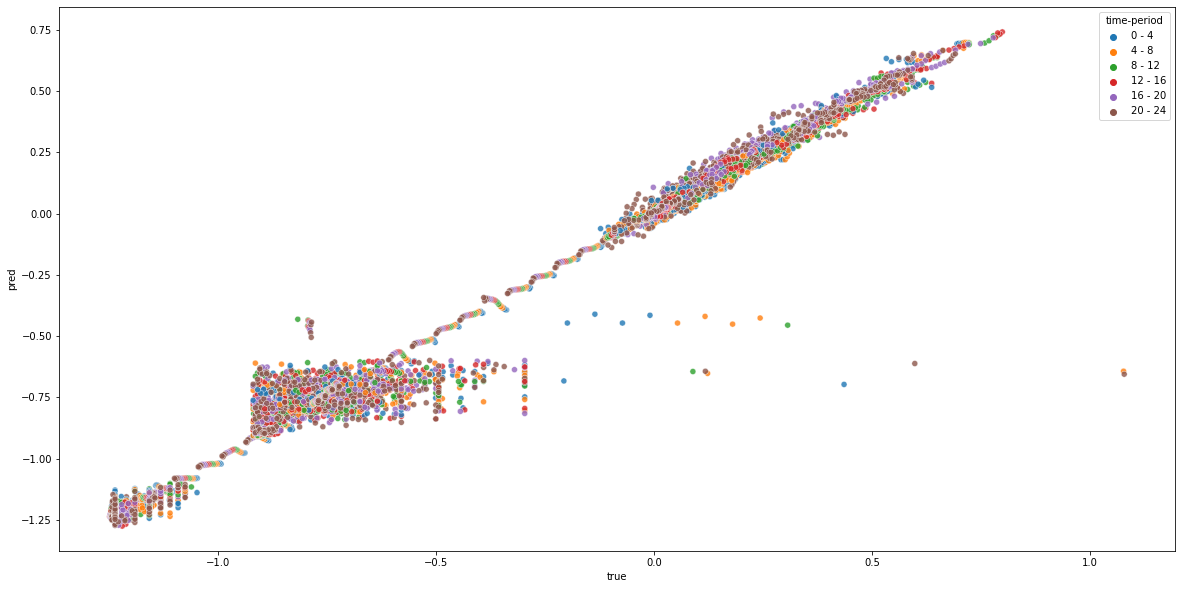

In [37]:
plot_scatter(true_seqs,pred_seqs,time_step=4,m_type='moisture',figsize=(20,10),alpha=0.8)

## 5 best and worst reconstruction errors

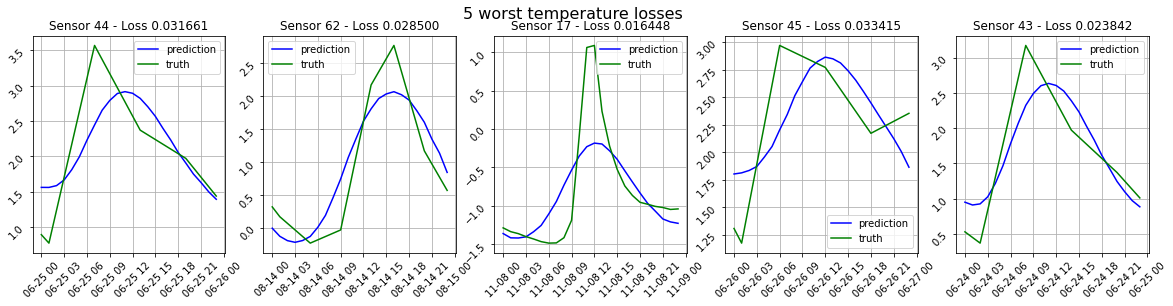

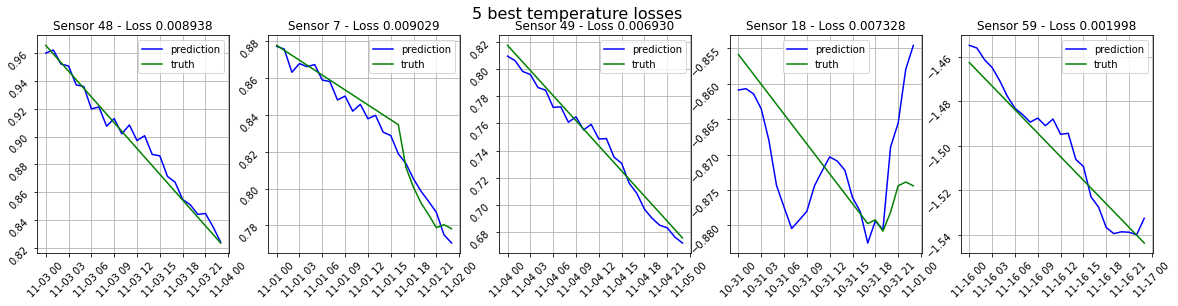

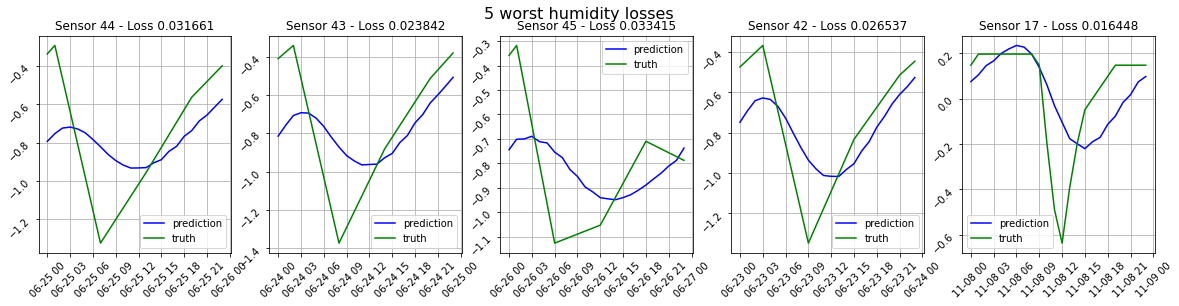

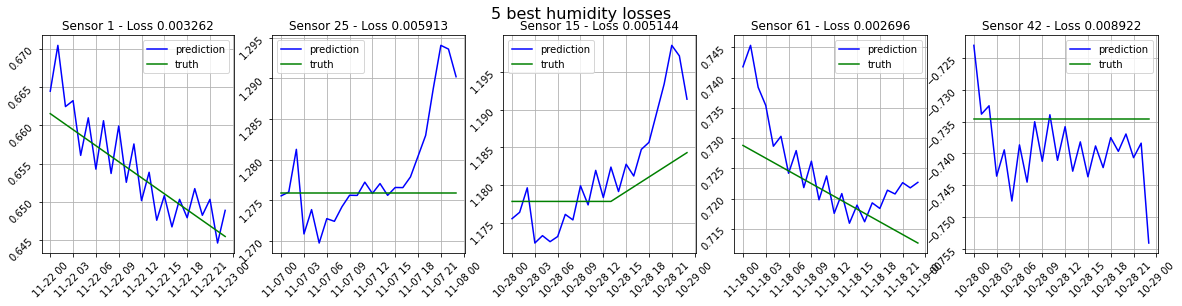

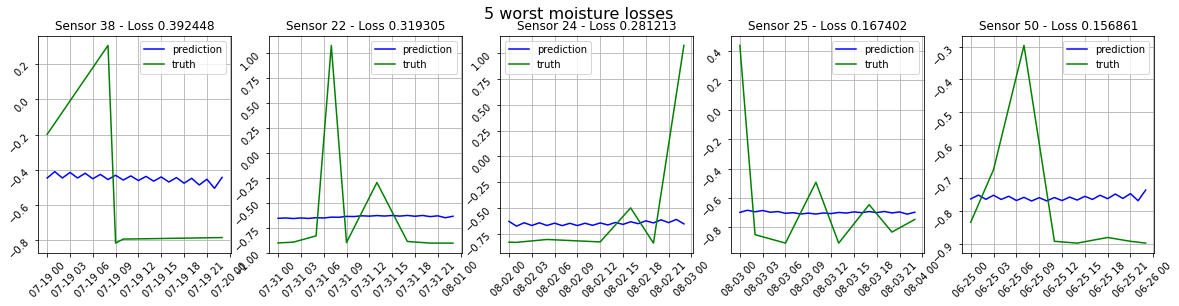

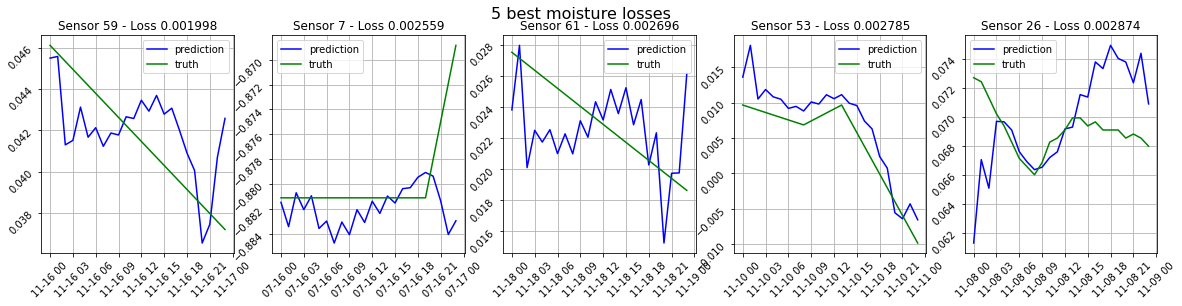

In [38]:
temp_losses, humidity_losses, moisture_losses, sensors_out, timestamps_out, temp_pred_out, humidity_pred_out, moisture_pred_out, temp_true_out, humidity_true_out, moisture_true_out = calc_global_losses(model,test_loader)

max_temp_loss, max_temp_loss_idx = calc_highest_losses(temp_losses,5)
min_temp_loss, min_temp_loss_idx = calc_lowest_losses(temp_losses,5)

max_moisture_loss, max_moisture_loss_idx = calc_highest_losses(moisture_losses,5)
min_moisture_loss, min_moisture_loss_idx = calc_lowest_losses(moisture_losses,5)

max_humidity_loss, max_humidity_loss_idx = calc_highest_losses(humidity_losses,5)
min_humidity_loss, min_humidity_loss_idx = calc_lowest_losses(humidity_losses,5)

plotGlobalLosses(temp_true_out,temp_pred_out,timestamps_out,max_temp_loss_idx,min_temp_loss_idx,sensors_out,temp_losses,humidity_losses,moisture_losses,param='temperature')
plotGlobalLosses(humidity_true_out,humidity_pred_out,timestamps_out,max_humidity_loss_idx,min_humidity_loss_idx,sensors_out,temp_losses,humidity_losses,moisture_losses,param='humidity')
plotGlobalLosses(moisture_true_out,moisture_pred_out,timestamps_out,max_moisture_loss_idx,min_moisture_loss_idx,sensors_out,temp_losses,humidity_losses,moisture_losses,param='moisture')

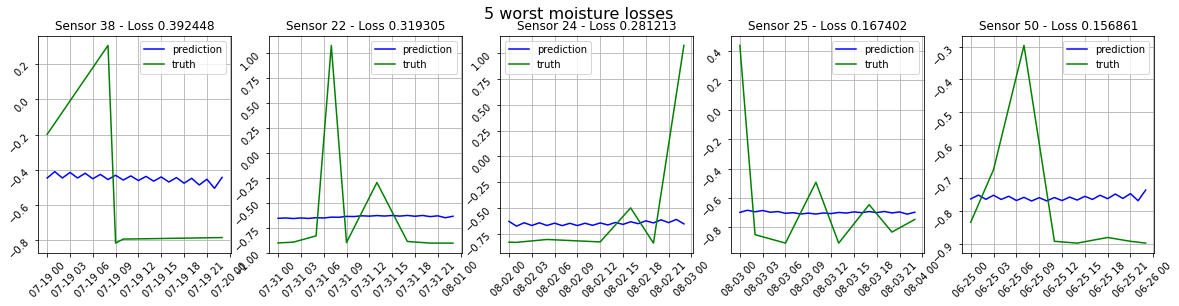

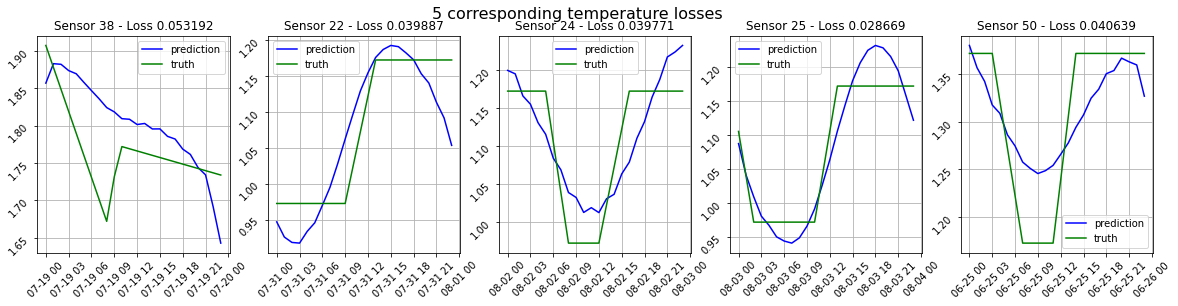

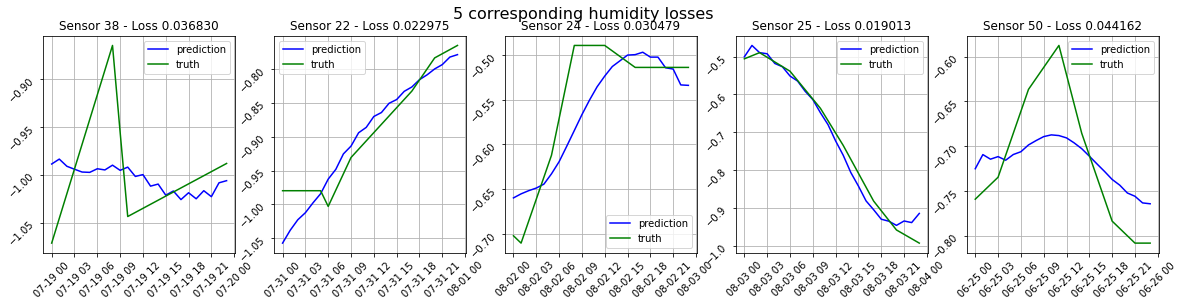

In [39]:
plot_corresponding_worst_losses(temp_true_out,temp_pred_out,humidity_true_out,humidity_pred_out,moisture_true_out,moisture_pred_out,timestamps_out,max_moisture_loss_idx,temp_losses,humidity_losses,moisture_losses,sensors_out)

       Temperature losses  Humidity losses  Moisture losses
count          427.000000       427.000000       427.000000
mean             0.061897         0.037466         0.030087
std              0.058279         0.030908         0.039997
min              0.005239         0.002953         0.001998
25%              0.021706         0.015493         0.008842
50%              0.041734         0.027879         0.015911
75%              0.080044         0.047794         0.031709
max              0.349395         0.204800         0.392448


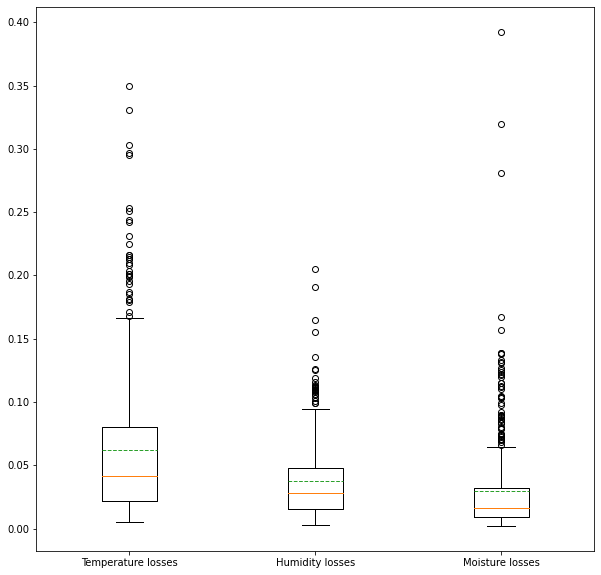

In [40]:
"""
Make a simple boxplot and summary statistics of the losses of the three parameters
"""
data = np.transpose(np.array([temp_losses,humidity_losses,moisture_losses]))
df = pd.DataFrame(data,columns=['Temperature losses','Humidity losses','Moisture losses'])
desc = df.describe()
print(desc)
plt.figure(figsize=(10,10))
fig = plt.boxplot([temp_losses,humidity_losses,moisture_losses],showmeans=True, meanline=True)
ax = plt.gca()
ax.set_xticklabels(["Temperature losses","Humidity losses","Moisture losses"])
plt.show()

## Histogram of mean moisture loss and point-based moisture loss

In [41]:
val_losses,num_samples = predict_on_all_samples(model,test_loader,de_standardize=True)
point_val_losses, num_samples = predict_on_all_points(model,test_loader,de_standardize=True)

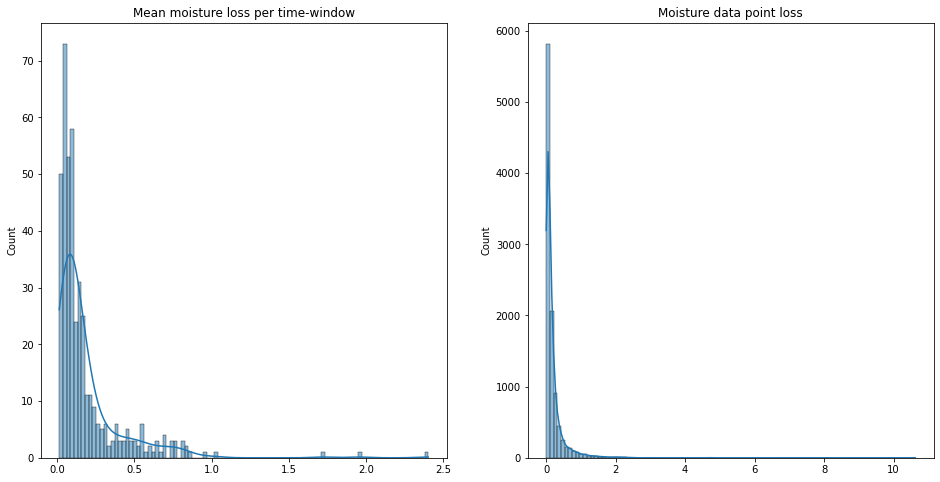

In [42]:
fig, axes = plt.subplots(1, 2,figsize=(16, 8))
sns.histplot(val_losses, bins=100, kde=True, ax=axes[0]).set_title('Mean moisture loss per time-window')
sns.histplot(point_val_losses, bins=100, kde=True, ax=axes[1]).set_title('Moisture data point loss')
plt.show()

Determening threshold that approx. gives the 5% worst reconstruction errors for the whole time window

In [43]:
#mean_threshold = 1.0
#(np.array(val_losses) >= mean_threshold).sum() / (num_samples)

Determining point-based threshold that approx. gives the 5% worst point-based reconstruction errors

In [44]:
#point_threshold = 1.2
#(np.array(point_val_losses)>=point_threshold).sum() / (num_samples*24)

## Boxplot for loss per hour

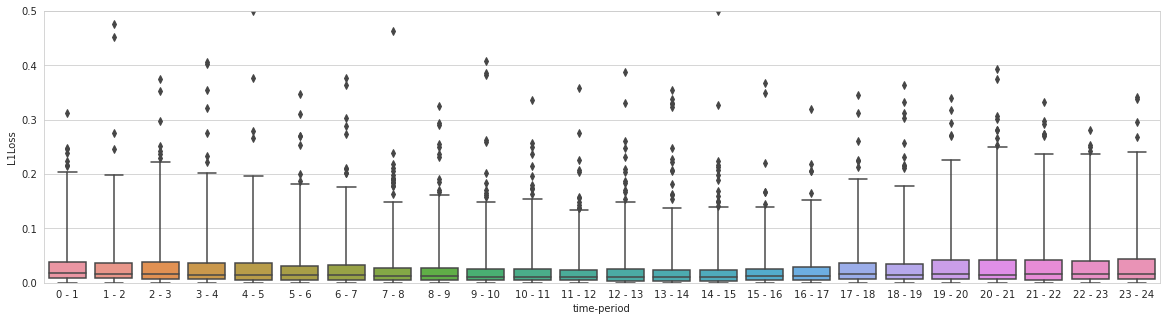

In [45]:
df_per_hour = box_plots_per_hour(true_seqs,pred_seqs,time_step = 1,m_type = 'moisture',
                                 loss='L1Loss',figsize=(20,5),ylim=0.5,
                                 whis=6)

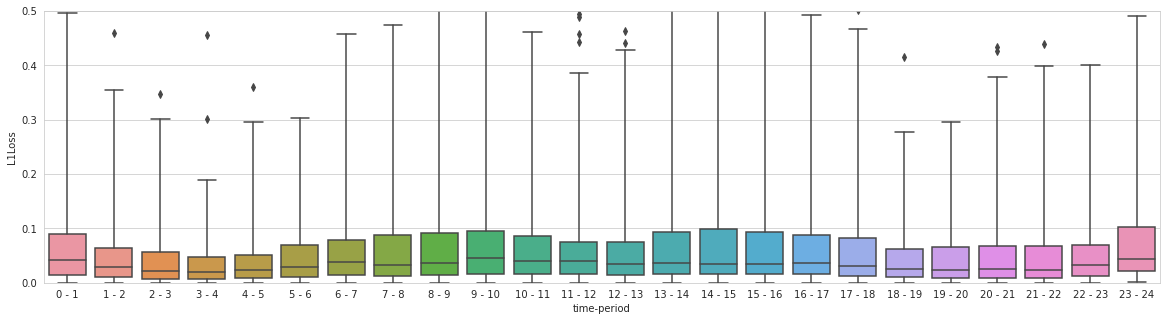

In [46]:
df_per_hour_temperature = box_plots_per_hour(true_seqs,pred_seqs,time_step = 1,m_type = 'temperature',
                                 loss='L1Loss',figsize=(20,5),ylim=0.5,
                                 whis=6)
thresholds_temperature = np.zeros((24))
for i,t in enumerate(df_per_hour_temperature['time-period'].unique()):
  df_t = df_per_hour_temperature[df_per_hour_temperature['time-period'] == t]
  thresholds_temperature[i] = df_t['L1Loss'].quantile(0.99)

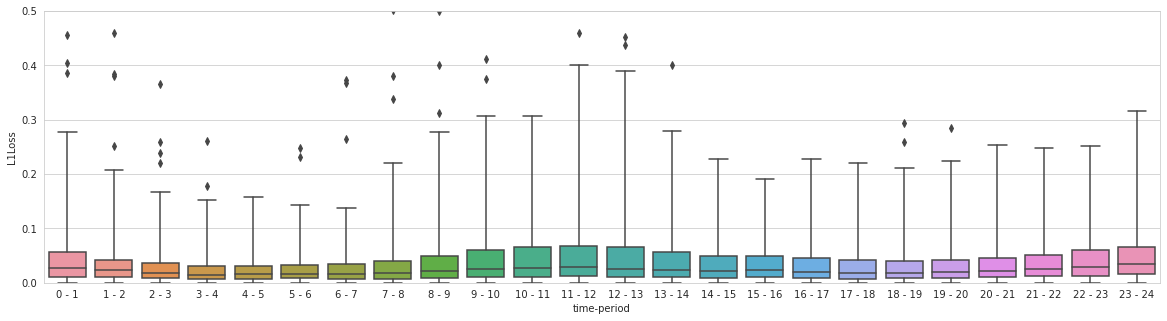

In [47]:
df_per_hour_humidity = box_plots_per_hour(true_seqs,pred_seqs,time_step = 1,m_type = 'humidity',
                                 loss='L1Loss',figsize=(20,5),ylim=0.5,
                                 whis=6)
thresholds_humidity = np.zeros((24))
for i,t in enumerate(df_per_hour_humidity['time-period'].unique()):
  df_t = df_per_hour_humidity[df_per_hour_humidity['time-period'] == t]
  thresholds_humidity[i] = df_t['L1Loss'].quantile(0.99)

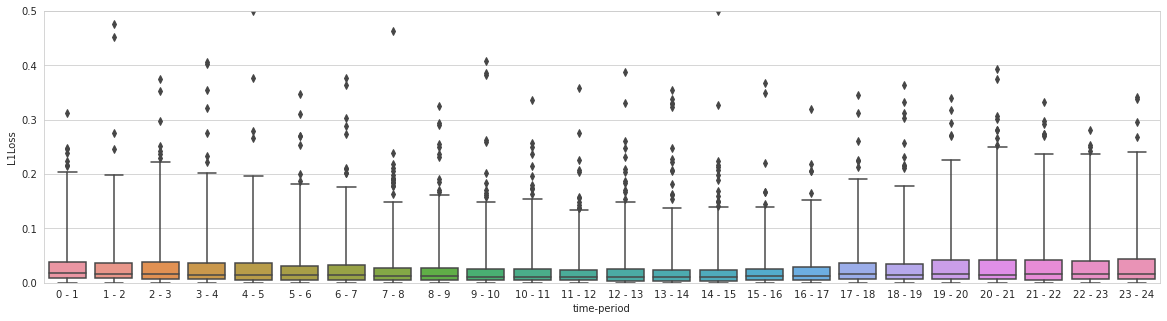

In [48]:
df_per_hour_moisture = box_plots_per_hour(true_seqs,pred_seqs,time_step = 1,m_type = 'moisture',
                                 loss='L1Loss',figsize=(20,5),ylim=0.5,
                                 whis=6)
thresholds_moisture = np.zeros((24))
for i,t in enumerate(df_per_hour_moisture['time-period'].unique()):
  df_t = df_per_hour_moisture[df_per_hour_moisture['time-period'] == t]
  thresholds_moisture[i] = df_t['L1Loss'].quantile(0.99)

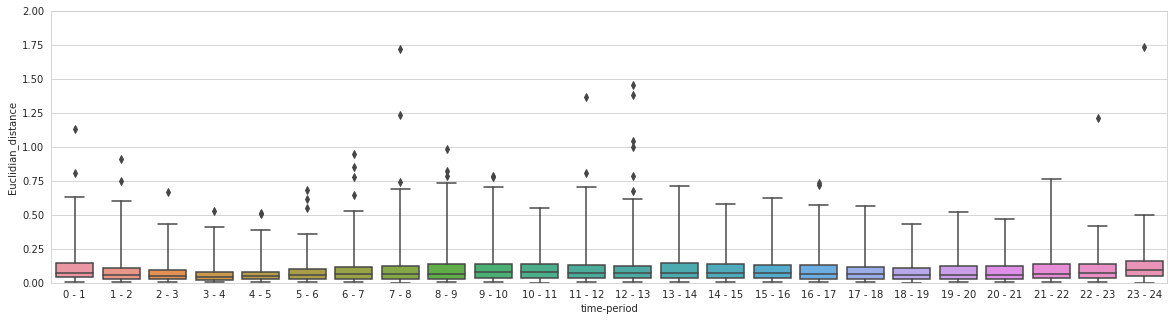

In [49]:
df_per_hour_euclidian = box_plots_per_hour(true_seqs,pred_seqs,time_step = 1,m_type = 'euclidian_all',
                                 loss='Euclidian_distance',figsize=(20,5),ylim=2,
                                 whis=6)
thresholds_euclidian = np.zeros((24))
for i,t in enumerate(df_per_hour_euclidian['time-period'].unique()):
  df_t = df_per_hour_euclidian[df_per_hour_euclidian['time-period'] == t]
  thresholds_euclidian[i] = df_t['Euclidian_distance'].quantile(0.99)

Making a dataframe with all the outlier thresholds for every hour and exporting this for the model comparison

In [50]:
threshold_df = pd.DataFrame({"timesteps":list(range(24)),
                             "temperature_threshold":thresholds_temperature,
                             "humidity_threshold":thresholds_humidity,
                             "moisture_threshold":thresholds_moisture,
                             "euclidian_threshold":thresholds_euclidian})
#threshold_df.to_csv("/content/drive/MyDrive/WoodSense/notebooks/Final models and comparison/GRU_AE_threshold.csv",index=False)

# Outlier detection with threshold
This section focuses on the outlier detection of the data


## Define functions for outlier detection and plotting

In [51]:
def return_outliers(model, loader,thresholds,only_moisture = True,de_standardize = True):
  """
  Computes where in the data there is outliers.

  Parameter:
  model: The trained model
  loader: the testloader
  thresholds: The thresholds for when to classify a point as an outlier
  only_moisture: if True, only returns outliers for moisture
  de_standardise: if True, de-standaridises the data
  """
  val_predictions, val_losses = [], []
  point_outliers = []
  point_non_outliers = []
  num_samples = 0
  criterion = nn.L1Loss(reduction='none').to(device)
  mean_criterion = nn.L1Loss(reduction='mean').to(device)
  num_outlier_windows = 0
  total_windows = 0

  with torch.no_grad():
    for batch in test_loader:
      test_batch, timestamps, sensors = batch
      test_batch = test_batch.to(device)
      num_samples += test_batch.shape[0]
      for sample_num in range(test_batch.shape[0]):
        total_windows += 1

        seq_true = test_batch[sample_num].unsqueeze(0)
        seq_pred = model(seq_true)

        seq_true = seq_true.cpu()
        seq_pred = seq_pred.cpu()

        timestamp = timestamps[sample_num,:]
        timestamp = pd.to_datetime(timestamp.numpy())
        sensor = sensors[sample_num]

        if de_standardize:
          mean = mean_and_std.loc[mean_and_std.measure == 'moisture','mean']
          std = mean_and_std.loc[mean_and_std.measure == 'moisture','std']

          seq_true = seq_true*std.values + mean.values
          seq_pred = seq_pred*std.values + mean.values

        if only_moisture:
          seq_true = seq_true[:,:,2]
          seq_pred = seq_pred[:,:,2]
        loss = criterion(seq_pred, seq_true)

        thres_dif = loss.numpy() - np.array(thresholds)
        #print(thres_dif)

        if (thres_dif > 0).any():
          num_outlier_windows += 1
          point_outlier_idx = thres_dif > 0
          point_outlier_tuple = (seq_true.numpy(),seq_pred.numpy(),loss.numpy().squeeze(),timestamp,sensor,point_outlier_idx.squeeze())
          point_outliers.append(point_outlier_tuple)
        else:
          point_non_outlier_tuple = (seq_true.numpy(),seq_pred.numpy(),loss.numpy(),timestamp,sensor)
          point_non_outliers.append(point_non_outlier_tuple)
        
  return point_outliers, point_non_outliers,num_outlier_windows, total_windows

In [52]:
def plot_point_outliers(point_outliers,num_outlier_windows,figsize=(30,30)):
  """
  Plots the found outliers

  Parameters:
  point_outliers: A set of information about the outlier containing true and predicted value, loss, timestamp, sensor and index of the outlier.
  num_outlier_windows: The number of outlier windows
  """
  import math
  ncols = 4
  nrows = math.ceil(num_outlier_windows/ncols)
  fig, axes = plt.subplots(figsize = figsize,ncols=ncols,nrows=nrows, sharex=False, sharey=False)

  for i, ax in enumerate(axes.flat):
    if i + 1 < num_outlier_windows:
      seq_true,seq_pred,loss,timestamp,sensor,outlier_idx  = point_outliers[i]

      time_range = np.arange(len(timestamp))

      seq_outlier = seq_true.reshape(24)[outlier_idx]
      outlier_time = time_range[outlier_idx]

      time_label = list(timestamp.time.astype(str))

      ax.plot(time_range,seq_pred.reshape(24),'b-',label='prediction')
      ax.plot(time_range,seq_true.reshape(24),'g-',label='truth')
      ax.plot(outlier_time,seq_outlier,'ro',label='outlier')
      ax.set_xticks(time_range[::2])
      ax.set_xticklabels(time_label[::2], rotation=45)
      ax.set_title(f'Sensor {sensor[0]} at {timestamp.date[0]}')
      ax.legend()

  plt.tight_layout()

In [53]:
def plot_mean_outliers(mean_outliers,num_outlier_windows):
  """
  Plots the mean of outliers

  Parameters:
  point_outliers: A set of information about the outlier containing true and predicted value, loss, timestamp, sensor and index of the outlier.
  num_outlier_windows: The number of outlier windows
  """
  ncols = 4
  nrows = math.ceil(num_samples/ncols)
  fig, axes = plt.subplots(figsize = (30,30),ncols=ncols,nrows=nrows, sharex=False, sharey=False)

  for i, ax in enumerate(axes.flat):
    if i + 1 < num_outlier_windows:
      seq_true,seq_pred,loss,timestamp,sensor = mean_outliers[i]

      time_range = np.arange(len(timestamp))
      time_label = list(timestamp.time.astype(str))

      ax.plot(time_range,seq_pred.reshape(24),'b-',label='prediction')
      ax.plot(time_range,seq_true.reshape(24),'g-',label='truth')
      ax.set_xticks(time_range[::2])
      ax.set_xticklabels(time_label[::2], rotation=45)
      ax.set_title(f'Sensor {sensor[0]} at {timestamp.date[0]} with mean loss {np.round(loss,2)}')
      ax.legend()

  plt.tight_layout()

## Find and plot outliers

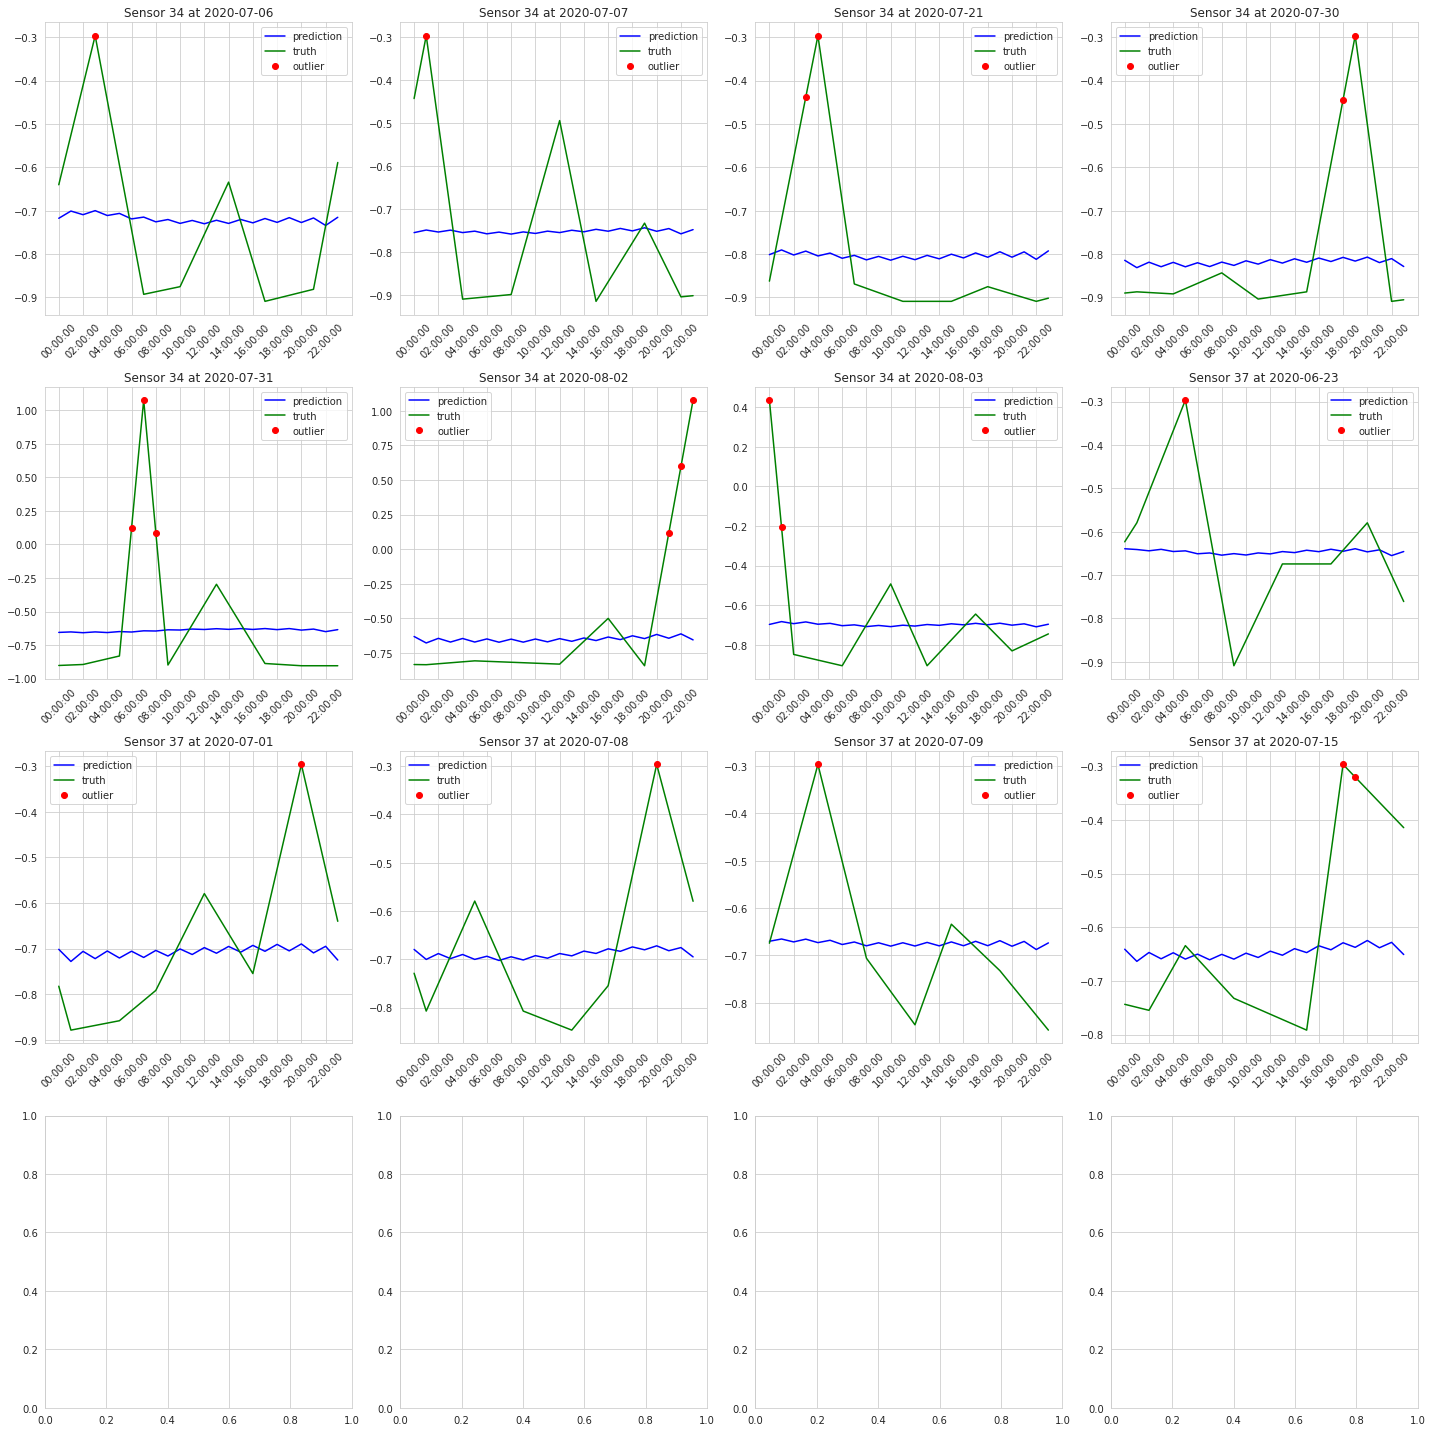

In [54]:
point_outliers, point_non_outliers,num_outlier_windows,total_windows = return_outliers(model,test_loader,only_moisture = True,thresholds=thresholds_euclidian,de_standardize = False)
plot_point_outliers(point_outliers,num_outlier_windows,figsize=(20,20))